# Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class Maze:
    '''Class defining the environment'''
    def __init__(self, shapex, shapey, holes, start, goal):
        self.shapex = shapex
        self.shapey = shapey
        self.walls  = walls
        self.start  = start
        self.goal   = goal
        self.idx    = self.build_index()
        self.size   = shapex * shapey
        self.bitmap = self.build_bitmap()
        
    def state_from_index(self, number):
        '''get state from index'''
        x = number // self.shapey
        y = number  % self.shapey
        
        return (x, y)
        
    def build_index(self):
        '''build index for indexing states'''
        return {(x, y) : self.shapey * x + y for x in range(self.shapex) 
                for y in range(self.shapey)}
        
    def build_bitmap(self):
        '''builds the bitmap for visualisation'''
        bitmap = np.ones((self.shapex, self.shapey))
        
        for wall in self.walls:
            bitmap[wall] = 0
        
        return bitmap
    
    def show_bitmap(self):
        '''shows the environment of holes and walkable path'''
        
        plt.imshow(self.bitmap)
    
    def show_path(self, path):
        '''
        path : list(tuple(int, int)) : sequence of states
        
        plots a given path onto the bitmap
        '''
        
        c0 = 5
        c1 = 6
        
        length    = len(path)
        maze      = self.bitmap.copy()
        fade      = np.linspace(c0, c1, num=length)
        
        for i in range(length):
            maze[path[i]] = fade[i]
            
        maze[self.start] = c0
        maze[self.goal]  = c1
        
        print(f"path length: {len(path)}")
        plt.imshow(maze)

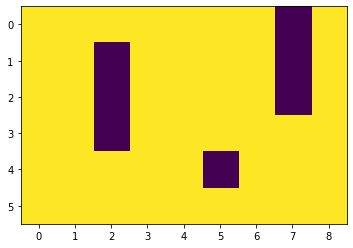

In [3]:
shapex = 6
shapey = 9
start  = (2, 0)
goal   = (0, 8)
walls  = [(1, 2), (2, 2), (3, 2), (4, 5), (0, 7), (1, 7), (2, 7)]

maze  = Maze(shapex, shapey, walls, start, goal)
maze.show_bitmap()

# Setup

In [4]:
moves     = [(-1, 0), (0, -1), (0, 1), (1, 0)]
move_idx  = {moves[i] : i for i in range(len(moves))}

In [5]:
def move(maze, pos, act):
    '''
    maze   : Maze            : Environment
    pos    : tuple(int, int) : Position in Environment
    act    : tuple(int, int) : Move direction
    
    Move from pos in direction act
    
    newpos : tuple(int, int) : New position
    '''
    
    oldpos = pos
    
    # Clamp values to map
    x_pos  = int(max(0, min(maze.shapex - 1, pos[0] + act[0])))
    y_pos  = int(max(0, min(maze.shapey - 1, pos[1] + act[1])))
    newpos = (x_pos, y_pos)
    
    # Reset position if falling in hole
    if newpos in maze.walls:
        newpos = oldpos
        
    reward = 1 if newpos == maze.goal else 0
    
    return newpos, reward

In [6]:
def epsilon_greedy_policy(Q, pos, epsilon=0.1):
    '''
    Q         : 3d np.array(), float : State-Action values
    pos       : tuple(int, int)      : Position in Environment
    epsilon   : float in [0, 1]      : Exploration / Exploitation Parameter
    
    Epsilon Greedy Policy. For a low epsilon value : high exploitation, low exploration
    
              : tuple(int, int)      : Decided Action according to policy
    '''
    
    global moves
    
    act_i = None
    r     = np.random.rand()
        
    if r > epsilon:
        act_i = np.argmax(Q[pos])
    else:
        act_i = np.random.randint(len(moves))
        
    return moves[act_i]

In [7]:
def trace(maze, Q):
    global moves
    
    S = maze.start
    A = moves[np.argmax(Q[S])]
    path = []
    
    while S != maze.goal:
        path.append(S)
        Sn, _ = move(maze, S, A)
        An    = moves[np.argmax(Q[Sn])]
        S     = Sn
        A     = An
        
        if Sn == maze.start or Sn in path:
            print("State Values dont create greedy path")
            break
    
    return path

# Dyna-Q
Debug `print()` statements left in to see if it gets stuck

In [18]:
def dyna_q(maze=maze, plan_steps=50, episodes=8000, alpha=0.5, epsilon=0.1, gamma=1):
    global moves
    
    '''
    Suffixes: 
        - n: next
        - p: planning
        - m: max
        - i: index
    '''
    
    #  Last size of M = 3: reward (int) and state (tuple(int, int))
    Q = np.random.rand(maze.shapex, maze.shapey, len(moves)) * 5 # Optimistic initialization
    M = np.zeros((maze.shapex, maze.shapey, len(moves), 3), dtype=int)
    
    history = [set()] * maze.size # History for planning part
    history_full = np.zeros(maze.size)
    
    for episode in range(episodes):
        S = maze.start
        print(episode)
        
        while True:
            print(S, end='\t')
            # Moving
            A     = epsilon_greedy_policy(Q, S, epsilon=epsilon)
            Sn, R = move(maze, S, A)
            
            # Only add to History if it isnt full yet
            if not history_full[maze.idx[S]]:
                history[maze.idx[S]].add(move_idx[A])
                if len(history[maze.idx[S]]) == 4:
                    history_full[maze.idx[S]] = 1

            # Direct Reinforcement Learning
            Am       = np.argmax(Q[Sn])
            idx      = (S[0],  S[1],  move_idx[A])
            idxn     = (Sn[0], Sn[1], Am)
            Q[idx]  += alpha * (R + gamma * Q[idxn] - Q[idx])

            # Model Learning
            M[idx]   = R, Sn[0], Sn[1]
            S        = Sn

            # Planning
            visited = [i for i, h in enumerate(history) if h]
            for step in range(plan_steps):
                Spi = random.choice(visited)
                Sp  = maze.state_from_index(Spi)
                Api = random.choice(tuple(history[Spi]))
                Rp  = M[Sp[0], Sp[1], Api, 0]
                Spn = tuple(M[Sp[0], Sp[1], Api, 1:])

                Apm     = np.argmax(Q[Spn])
                idx     = (Sp[0],  Sp[1],  Api)
                idxn    = (Spn[0], Spn[1], Apm)
                Q[idx] += alpha * (Rp + gamma * Q[idxn] - Q[idx])
                
            # Next Episode if Goal reached
            if Sn == maze.goal:
                break
            
    return Q, M

# Result

the Dyna-Q Algorithm seems to not reach the goal everytime. It very often got stuck going back and forth in the topmost row. We need a bit of luck to reach the goal in the first episode

In [26]:
Q, M = dyna_q(plan_steps=10, episodes=10000)

0
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 

(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(1, 4)
(1, 4)	(1, 5)
(1, 5)	(0, 5)
(0, 5)	(0, 6)
(0, 6)	(1, 6)
(1, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 

(2, 8)	(1, 8)
(1, 8)	(0, 8)
32
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
33
(2, 0)	(2, 1)
(2, 1)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
34
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
35
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(

(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
75
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
76
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
77
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
78
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(

(2, 8)	(1, 8)
(1, 8)	(0, 8)
118
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
119
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(5, 0)
(5, 0)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
120
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
121
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
122
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)


(1, 8)	(0, 8)
162
(2, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
163
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
164
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
165
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
166
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)


(2, 8)	(1, 8)
(1, 8)	(0, 8)
202
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
203
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
204
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
205
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
206


(2, 8)	(1, 8)
(1, 8)	(0, 8)
241
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
242
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
243
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
244
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
245
(2, 0)	(3, 0)
(3, 0)	(4, 0)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
282
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(1, 6)
(1, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
283
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
284
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
285
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
286
(2, 0)	(3, 0)


(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
323
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
324
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
325
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
326
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 

(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
369
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
370
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
371
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
372
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 

(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
409
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
410
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
411
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
412
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 

(2, 8)	(1, 8)
(1, 8)	(0, 8)
456
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
457
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
458
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
459
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 

(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
501
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
502
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
503
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
504
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 

(2, 8)	(1, 8)
(1, 8)	(0, 8)
542
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
543
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
544
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
545
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
546


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
584
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
585
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
586
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
587
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
588
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)


(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
625
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
626
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
627
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
628
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 

(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
673
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
674
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
675
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
676
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 

(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
718
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
719
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
720
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
721
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 

(1, 8)	(0, 8)
761
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
762
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
763
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
764
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
765


(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
802
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
803
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
804
(2, 0)	(2, 1)
(2, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
805
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 

(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
845
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
846
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
847
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
848
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 

(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
886
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
887
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
888
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
889
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
890
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
933
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
934
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
935
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
936
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 

(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
980
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
981
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
982
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
983
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1024
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1025
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1026
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1027
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1071
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1072
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1073
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1074
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1118
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1119
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1120
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1121
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1160
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1161
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1162
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1163
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1164
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4

(3, 0)	(4, 0)
(4, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1204
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1205
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1206
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1207
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1247
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1248
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1249
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1250
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1251
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3

(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1290
(2, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
1291
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1292
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1293
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1333
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1334
(2, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1335
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1336
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(2, 8)	(1, 8)
(1, 8)	(0, 8)
1377
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1378
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1379
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1380
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1381
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4

(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1421
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1422
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1423
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1424
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1425
(2, 0)	(2

(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1466
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1467
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
1468
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1469
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1512
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1513
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1514
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1515
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1516
(2, 0)	(3

(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1557
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1558
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1559
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1560
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1603
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1604
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1605
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1606
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1607
(2, 0)	(3

(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1648
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1649
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1650
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1651
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1695
(2, 0)	(2, 1)
(2, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1696
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1697
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1698
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)


(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1740
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
1741
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1742
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1743
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1787
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1788
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1789
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1790
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1791
(2, 0)	(3, 0)
(3, 0)	(3

(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1835
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1836
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1837
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1838
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1881
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1882
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
1883
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1884
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1927
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1928
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1929
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1930
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1931
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3

(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1974
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1975
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1976
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
1977
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2021
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2022
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2023
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2024
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2025
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4

(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2068
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2069
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2070
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2071
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2113
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2114
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2115
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2116
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2159
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2160
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2161
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2162
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2163
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3

(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2205
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2206
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2207
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2208
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2209
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2251
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2252
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2253
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2254
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2255
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4

(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2299
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2300
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2301
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2302
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2343
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2344
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2345
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2346
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2390
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2391
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2392
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2393
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2430
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2431
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2432
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2433
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2472
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2473
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2474
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2475
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2476
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4

(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2517
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2518
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2519
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2520
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2562
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2563
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2564
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2565
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2608
(2, 0)	(2, 1)
(2, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2609
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2610
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2611
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2612
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4

(2, 8)	(1, 8)
(1, 8)	(0, 8)
2656
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2657
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2658
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2659
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2660
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2704
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2705
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2706
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2707
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2708
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4

(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2751
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2752
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2753
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2754
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2755
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3

(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2801
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2802
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2803
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2804
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2805
(2, 0)	(3

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2849
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2850
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2851
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2852
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(4, 8)
(4, 8)	(5, 8)
(5, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2853
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5

(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2899
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2900
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2901
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2902
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2903
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4

(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2950
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2951
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2952
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2953
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
2999
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3000
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3001
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3002
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3047
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3048
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3049
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3050
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)


(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3095
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
3096
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3097
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3098
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3099
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4

(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3142
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3143
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3144
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3145
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3146
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3189
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3190
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3191
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3192
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(1, 8)	(0, 8)
3234
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
3235
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3236
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3237
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3238
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3

(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3281
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3282
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3283
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3284
(2, 0)	(3, 0)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3329
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3330
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3331
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3332
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3333
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4

(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3379
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3380
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3381
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3382
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)


(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3423
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3424
(2, 0)	(1, 0)
(1, 0)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3425
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3426
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3469
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3470
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3471
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3472
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3473
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4

(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3519
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3520
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3521
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3522
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)


(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3564
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3565
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3566
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3567
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3568
(2, 0)	(2

(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3611
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3612
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3613
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3614
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)


(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3658
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3659
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3660
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3661
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
3704
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3705
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3706
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3707
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3708
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3749
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3750
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3751
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3752
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3753
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4

(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3795
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3796
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3797
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3798
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(5, 0)
(5, 0)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3799
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4

(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3841
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3842
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3843
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3844
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3845
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4

(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3891
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3892
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3893
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3894
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3937
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(5, 0)
(5, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3938
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3939
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3940
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3981
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3982
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3983
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3984
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
3985
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3

(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
4031
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4032
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4033
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4034
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4080
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4081
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4082
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4083
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4084
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(5

(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4127
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4128
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4129
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4130
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)


(2, 8)	(1, 8)
(1, 8)	(0, 8)
4172
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4173
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4174
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
4175
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4176
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3

(1, 8)	(0, 8)
4220
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4221
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4222
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4223
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 0)
(5, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4224
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4

(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4266
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4267
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4268
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4269
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4313
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4314
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4315
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4316
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4358
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
4359
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4360
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4361
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4406
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4407
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4408
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4409
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4410
(2, 0)	(1, 0)
(1, 0)	(2

(1, 8)	(0, 8)
4455
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4456
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4457
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4458
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4504
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4505
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4506
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
4507
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4550
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4551
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4552
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4553
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)


(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4598
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4599
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4600
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4601
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


4645
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4646
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4647
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4648
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4649
(2, 0)	(3, 0)
(3, 0)	(3

(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4691
(2, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4692
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4693
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4694
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4738
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4739
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4740
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4741
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4783
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4784
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4785
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4786
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4787
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4

(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4828
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4829
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4830
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4831
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4875
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4876
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4877
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4878
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4879
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4

(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4923
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4924
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
4925
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(4, 7)
(4, 7)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4926
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4927
(2, 0)	(2

(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4971
(2, 0)	(1, 0)
(1, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4972
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4973
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
4974
(2, 0)	(3, 0)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5015
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5016
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5017
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5018
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5019
(2, 0)	(3, 0)
(3, 0)	(4

(2, 8)	(1, 8)
(1, 8)	(0, 8)
5061
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5062
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5063
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5064
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5065
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3

(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5109
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(1, 0)
(1, 0)	(0, 0)
(0, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5110
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5111
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5112
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)


(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5156
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5157
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
5158
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5159
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5204
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5205
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5206
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5207
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5251
(2, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5252
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5253
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5254
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5292
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5293
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5294
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
5295
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5339
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5340
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(5, 0)
(5, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5341
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5342
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5387
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5388
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5389
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5390
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5433
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5434
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5435
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5436
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)


(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5479
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5480
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5481
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5482
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5524
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5525
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5526
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5527
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5569
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5570
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5571
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5572
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5617
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5618
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5619
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5620
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
5665
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5666
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5667
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5668
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5669
(2, 0)	(2

(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5713
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5714
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5715
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5716
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
5758
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5759
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5760
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5761
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)


(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5806
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5807
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5808
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5809
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)


(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5849
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5850
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5851
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5852
(2, 0)	(2, 1)
(2, 1)	(3, 1)


(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5890
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5891
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5892
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5893
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5894
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5936
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5937
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5938
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5939
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5940
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3

(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5982
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5983
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5984
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
5985
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6029
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6030
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6031
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6032
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
6033
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3

(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6077
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6078
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6079
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6080
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6123
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6124
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6125
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6126
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6127
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4

(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6170
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6171
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6172
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6173
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6217
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6218
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6219
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6220
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6221
(2, 0)	(3

(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6262
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6263
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6264
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6265
(2, 0)	(2, 1)
(2, 1)	(2, 1)


(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6307
(2, 0)	(2, 1)
(2, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6308
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6309
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6310
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6355
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6356
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6357
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6358
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6401
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6402
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6403
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6404
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6451
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6452
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6453
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6454
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6498
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6499
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6500
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6501
(2, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6502
(2, 0)	(2, 1)
(2, 1)	(3

(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6548
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6549
(2, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6550
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6551
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6552
(2, 0)	(2

(1, 8)	(0, 8)
6591
(2, 0)	(2, 1)
(2, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6592
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6593
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6594
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6637
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6638
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6639
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6640
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6641
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4

(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6686
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6687
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6688
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6689
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6732
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6733
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6734
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6735
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(1, 5)
(1, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6777
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6778
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6779
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6780
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


6820
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6821
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6822
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6823
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 0)
(4, 0)	(5, 0)
(5, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6824
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4

(2, 8)	(1, 8)
(1, 8)	(0, 8)
6866
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6867
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6868
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6869
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6870
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(5

(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6914
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6915
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6916
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6917
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6955
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6956
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6957
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
6958
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(5, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7002
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7003
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7004
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7005
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7045
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7046
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7047
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7048
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)


(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7090
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7091
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7092
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(5, 3)
(5, 3)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7093
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)


(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7133
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7134
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7135
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7136
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(2, 8)	(1, 8)
(1, 8)	(0, 8)
7177
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7178
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7179
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7180
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7181
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3

(1, 8)	(0, 8)
7223
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7224
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7225
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7226
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7227
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4

(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7269
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7270
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7271
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
7272
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)


(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7315
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7316
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7317
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7318
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
7359
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7360
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7361
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7362
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7403
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7404
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7405
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7406
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7407
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4

(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7447
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7448
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7449
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7450
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7451
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3

(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7494
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(4, 8)
(4, 8)	(5, 8)
(5, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7495
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7496
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7497


(1, 8)	(0, 8)
7537
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(5, 0)
(5, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7538
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7539
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7540
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7541
(2, 0)	(3, 0)
(3, 0)	(4

(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7582
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7583
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7584
(2, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7585
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7627
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7628
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7629
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7630
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(2, 8)	(1, 8)
(1, 8)	(0, 8)
7670
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
7671
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7672
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7673
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7674
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4

(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7713
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7714
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7715
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7716
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)


(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7761
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7762
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7763
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7764
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)


(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7809
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7810
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7811
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7812
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7813
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4

(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
7856
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7857
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7858
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7859
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7902
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7903
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7904
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7905
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7906
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4

(3, 8)	(4, 8)
(4, 8)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7945
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7946
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7947
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7948
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7991
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7992
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7993
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
7994
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8037
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
8038
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8039
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8040
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8041
(2, 0)	(3

(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8086
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8087
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8088
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8089
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)


(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8132
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8133
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8134
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8135
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)


(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8179
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8180
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8181
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8182
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8226
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8227
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8228
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8229
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8272
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
8273
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8274
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8275
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8276
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5

(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8318
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8319
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8320
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8321
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8365
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8366
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8367
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8368
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8412
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8413
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8414
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(2, 3)
(2, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8415
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)


(1, 8)	(0, 8)
8455
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8456
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8457
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8458
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8459
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1

(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8504
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8505
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8506
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8507
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(4, 8)
(4, 8)	(3, 8)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8552
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8553
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8554
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8555
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)


(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8598
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8599
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8600
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8601
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)


(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8646
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
8647
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8648
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8649
(2, 0)	(2, 1)
(2, 1)	(1, 1)
(1, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8693
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8694
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8695
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8696
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8741
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8742
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8743
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8744
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)


(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8786
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8787
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8788
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8789
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8790
(2, 0)	(2, 1)
(2, 1)	(3

(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
8833
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8834
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8835
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8836
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)


(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8879
(2, 0)	(2, 1)
(2, 1)	(2, 0)
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8880
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8881
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8882
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8922
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8923
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8924
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8925
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8926
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4

(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8968
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8969
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8970
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8971
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
8972
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4

(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9014
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9015
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9016
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9017
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9018
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3

(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9064
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9065
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9066
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9067
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)


(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9112
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9113
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9114
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9115
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9158
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9159
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9160
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9161
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9203
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9204
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9205
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9206
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(4, 0)	(5, 0)
(5, 0)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9245
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9246
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9247
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9248
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)


(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(5, 5)
(5, 5)	(5, 6)
(5, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9286
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9287
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9288
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9289
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 4)
(4, 4)	(3, 4)


(1, 8)	(0, 8)
9330
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(2, 5)
(2, 5)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9331
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9332
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
9333
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9334
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4

(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9370
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9371
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9372
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
9373
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)


(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9410
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(2, 5)
(2, 5)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9411
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9412
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9413
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
9414
(2, 0)	(2

(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(4, 6)
(4, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9453
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9454
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9455
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9456
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 2)
(5, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)


(1, 8)	(0, 8)
9494
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9495
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(4, 8)
(4, 8)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9496
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9497
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)


(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9537
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9538
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9539
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9540
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)


(1, 8)	(0, 8)
9580
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9581
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9582
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9583
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 7)
(3, 7)	(4, 7)
(4, 7)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
9584
(2, 0)	(3

(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9624
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(2, 4)
(2, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9625
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9626
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9627
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9671
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9672
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9673
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9674
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9675
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4

(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9720
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9721
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
9722
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(5, 4)
(5, 4)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9723
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)


(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9769
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9770
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9771
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9772
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(5, 1)
(5, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(3, 8)


(2, 8)	(1, 8)
(1, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9815
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9816
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9817
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9818
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9819
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(4

(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9863
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(1, 8)
(1, 8)	(0, 8)
9864
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(2, 3)
(2, 3)	(2, 4)
(2, 4)	(2, 5)
(2, 5)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9865
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9866
(2, 0)	(3, 0)
(3, 0)	(4, 0)
(4, 0)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)


(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(2, 6)
(2, 6)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9908
(2, 0)	(1, 0)
(1, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9909
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9910
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)
(4, 4)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9911
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(4, 4)


(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9954
(2, 0)	(3, 0)
(3, 0)	(2, 0)
(2, 0)	(2, 1)
(2, 1)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9955
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(5, 2)
(5, 2)	(5, 3)
(5, 3)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9956
(2, 0)	(3, 0)
(3, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9957
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4, 2)
(4, 2)	(4, 3)
(4, 3)	(3, 3)
(3, 3)	(3, 4)
(3, 4)	(3, 5)
(3, 5)	(3, 6)
(3, 6)	(3, 7)
(3, 7)	(3, 8)
(3, 8)	(2, 8)
(2, 8)	(1, 8)
(1, 8)	(0, 8)
9958
(2, 0)	(3, 0)
(3, 0)	(3, 1)
(3, 1)	(4, 1)
(4, 1)	(4

# Path from Start to Goal 

path length: 14


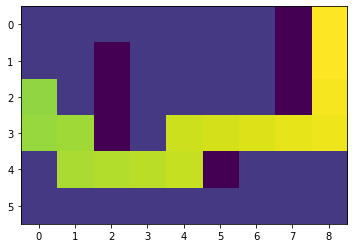

In [27]:
path = trace(maze, Q)
maze.show_path(path)

# Direction map
* purple : wall
* blue   : go up
* green  : go right
* yellow : go down

Goal is shown in yellow at the top right too

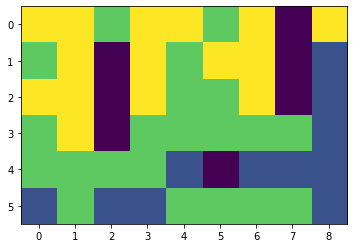

In [58]:
directions = [((x, y), np.argmax(Q[x, y])) for x in range(maze.shapex) for y in range(maze.shapey)]   
grid = np.full((maze.shapex, maze.shapey), -1)

for i in directions:
    if i[0] not in 

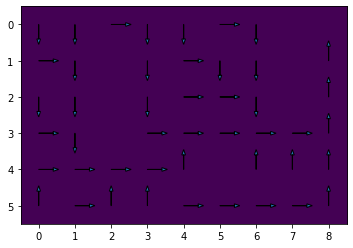

In [75]:


plt.imshow(grid)
for i in directions:
    if i[0] not in maze.walls and i[0] != maze.goal:
        dx = 0.4 if i[1] == 2 else 0

        dy = 0
        if i[1] == 0:
            dy = -0.4
        elif i[1] == 3:
            dy = 0.4

        plt.arrow(i[0][1], i[0][0], dx, dy, head_width = 0.1)
plt.show()